https://stackoverflow.com/questions/73834673/calculation-of-rolling-speed-in-a-pandasdataframe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data1 = {
    'ArucoID' : [910, 910, 910, 910, 910, 898, 898, 898, 898, 898, 912, 912, 912, 912, 912],
    'Subtrial' : ['01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01'],
    'frameID' : [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'xPos' : [10.0, 10.5, 11.0, 12.0, 13, 4.0, 5.0, 6.0, 7.0, 9.0, 1.5, 2.0, 2.5, 3.0, 4.0 ],
    'yPos' : [-0.2, -0.1, -0.1, 0.0, 0.0, 0.2, 0.2, -0.1, 0.0, 0.05, -0.2, -0.1, 0.0, 0.1, 0.05],
}

data2 = {
    'ArucoID' : [910, 910, 910, 910, 910, 898, 898, 898, 898, 898, 912, 912, 912, 912, 912],
    'Subtrial' : ['02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02', '02'],
    'frameID' : [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'xPos' : [9.4, 9.5, 9.0, 9.0, 10, 3.0, 4.0, 5.0, 6.0, 7.0, 2.5, 3.0, 3.5, 3.5, 5.0 ],
    'yPos' : [-0.2, -0.1, -0.1, 0.0, 0.0, 0.2, 0.2, -0.1, 0.0, 0.05, -0.2, -0.1, 0.0, 0.1, 0.05],
}

df = pd.concat([
    pd.DataFrame(data1),
    pd.DataFrame(data2) 
])

In [2]:
df = df.sort_values(["ArucoID", "Subtrial", "frameID"])

In [3]:
shifted = df.groupby(["ArucoID", "Subtrial"]).shift(-1)
shifted = shifted.drop("frameID", axis=1).rename(columns=lambda x: x + "_")


In [4]:
data = pd.concat([df, shifted], axis=1)
print(data)

    ArucoID Subtrial  frameID  xPos  yPos  xPos_  yPos_
5       898       01        1   4.0  0.20    5.0   0.20
6       898       01        2   5.0  0.20    6.0  -0.10
7       898       01        3   6.0 -0.10    7.0   0.00
8       898       01        4   7.0  0.00    9.0   0.05
9       898       01        5   9.0  0.05    NaN    NaN
5       898       02        1   3.0  0.20    4.0   0.20
6       898       02        2   4.0  0.20    5.0  -0.10
7       898       02        3   5.0 -0.10    6.0   0.00
8       898       02        4   6.0  0.00    7.0   0.05
9       898       02        5   7.0  0.05    NaN    NaN
0       910       01        1  10.0 -0.20   10.5  -0.10
1       910       01        2  10.5 -0.10   11.0  -0.10
2       910       01        3  11.0 -0.10   12.0   0.00
3       910       01        4  12.0  0.00   13.0   0.00
4       910       01        5  13.0  0.00    NaN    NaN
0       910       02        1   9.4 -0.20    9.5  -0.10
1       910       02        2   9.5 -0.10    9.0

In [5]:
def distance(x):
    return np.sqrt(np.power(x["xPos"] - x["xPos_"], 2) + np.power(x["yPos"] - x["yPos_"], 2))

In [6]:
data["dist"] = data.apply(distance, axis=1)

In [7]:
data["point_speed"] = data["dist"]/(1/30)
data["mov_speed"] = data.groupby(["ArucoID", "Subtrial"]).rolling(3, min_periods=1).mean()["point_speed"].values

In [8]:
print(data)

    ArucoID Subtrial  frameID  xPos  yPos  xPos_  yPos_      dist  \
5       898       01        1   4.0  0.20    5.0   0.20  1.000000   
6       898       01        2   5.0  0.20    6.0  -0.10  1.044031   
7       898       01        3   6.0 -0.10    7.0   0.00  1.004988   
8       898       01        4   7.0  0.00    9.0   0.05  2.000625   
9       898       01        5   9.0  0.05    NaN    NaN       NaN   
5       898       02        1   3.0  0.20    4.0   0.20  1.000000   
6       898       02        2   4.0  0.20    5.0  -0.10  1.044031   
7       898       02        3   5.0 -0.10    6.0   0.00  1.004988   
8       898       02        4   6.0  0.00    7.0   0.05  1.001249   
9       898       02        5   7.0  0.05    NaN    NaN       NaN   
0       910       01        1  10.0 -0.20   10.5  -0.10  0.509902   
1       910       01        2  10.5 -0.10   11.0  -0.10  0.500000   
2       910       01        3  11.0 -0.10   12.0   0.00  1.004988   
3       910       01        4  12.

In [9]:
final = data.groupby(["ArucoID", "Subtrial"]).agg({"dist": "sum", "frameID": "count"}).rename(columns={"frameID": "count"})

In [10]:
print(final)

                      dist  count
ArucoID Subtrial                 
898     01        5.049643      5
        02        4.050267      5
910     01        3.014890      5
        02        1.741421      5
912     01        2.530955      5
        02        2.620637      5


In [11]:
def speed(x, frame_time=1.):
    return x["dist"]/((x["count"] - 1)*frame_time)

In [12]:
final["avg_speed"] = final.apply(speed, axis=1, frame_time=1/30)
print(final)

                      dist  count  avg_speed
ArucoID Subtrial                            
898     01        5.049643      5  37.872323
        02        4.050267      5  30.377006
910     01        3.014890      5  22.611671
        02        1.741421      5  13.060660
912     01        2.530955      5  18.982163
        02        2.620637      5  19.654778


In [13]:
final = data.merge(final["avg_speed"], left_on=["ArucoID", "Subtrial"], right_index=True)
final["speed_ratio"] = final["mov_speed"]/final["avg_speed"]
final["speed_excess"] = 1. - final["speed_ratio"]
final

,ArucoID,Subtrial,frameID,xPos,yPos,xPos_,yPos_,dist,point_speed,mov_speed,avg_speed,speed_ratio,speed_excess
5,898,01,1,4.0,0.20,5.0,0.20,1.000000,30.000000,30.000000,37.872323,0.792135,0.207865
6,898,01,2,5.0,0.20,6.0,-0.10,1.044031,31.320920,30.660460,37.872323,0.809574,0.190426
7,898,01,3,6.0,-0.10,7.0,0.00,1.004988,30.149627,30.490182,37.872323,0.805078,0.194922
8,898,01,4,7.0,0.00,9.0,0.05,2.000625,60.018747,40.496431,37.872323,1.069288,-0.069288
9,898,01,5,9.0,0.05,NaN,NaN,NaN,NaN,45.084187,37.872323,1.190426,-0.190426
5,898,02,1,3.0,0.20,4.0,0.20,1.000000,30.000000,30.000000,30.377006,0.987589,0.012411
6,898,02,2,4.0,0.20,5.0,-0.10,1.044031,31.320920,30.660460,30.377006,1.009331,-0.009331
7,898,02,3,5.0,-0.10,6.0,0.00,1.004988,30.149627,30.490182,30.377006,1.003726,-0.003726
8,898,02,4,6.0,0.00,7.0,0.05,1.001249,30.037477,30.502674,30.377006,1.004137,-0.004137
9,898,02,5,7.0,0.05,NaN,NaN,NaN,NaN,30.093552,30.377006,0.990669,0.009331


In [14]:
print(final[:6])

   ArucoID Subtrial  frameID  xPos  yPos  xPos_  yPos_      dist  point_speed  \
5      898       01        1   4.0  0.20    5.0   0.20  1.000000    30.000000   
6      898       01        2   5.0  0.20    6.0  -0.10  1.044031    31.320920   
7      898       01        3   6.0 -0.10    7.0   0.00  1.004988    30.149627   
8      898       01        4   7.0  0.00    9.0   0.05  2.000625    60.018747   
9      898       01        5   9.0  0.05    NaN    NaN       NaN          NaN   
5      898       02        1   3.0  0.20    4.0   0.20  1.000000    30.000000   

   mov_speed  avg_speed  speed_ratio  speed_excess  
5  30.000000  37.872323     0.792135      0.207865  
6  30.660460  37.872323     0.809574      0.190426  
7  30.490182  37.872323     0.805078      0.194922  
8  40.496431  37.872323     1.069288     -0.069288  
9  45.084187  37.872323     1.190426     -0.190426  
5  30.000000  30.377006     0.987589      0.012411  


In [18]:
cross = final.pivot_table(index="frameID", columns=["ArucoID", "Subtrial"], values=["point_speed", "mov_speed", "avg_speed", "speed_ratio", "speed_excess"])

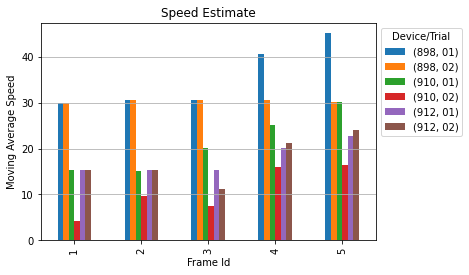

In [19]:
axe = cross["mov_speed"].plot(kind="bar")
axe.set_xlabel("Frame Id")
axe.set_ylabel("Moving Average Speed")
axe.set_title("Speed Estimate")
axe.legend(bbox_to_anchor=(1,1), title="Device/Trial")
axe.grid(axis="y")

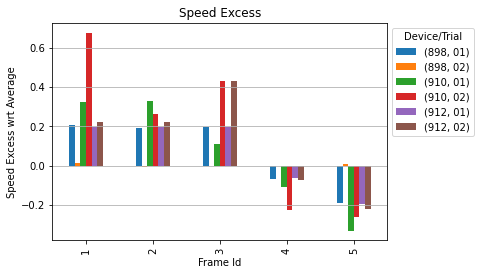

In [23]:
axe = cross["speed_excess"].plot(kind="bar")
axe.set_xlabel("Frame Id")
axe.set_ylabel("Speed Excess wrt Average")
axe.set_title("Speed Excess")
axe.legend(bbox_to_anchor=(1,1), loc="upper left", title="Device/Trial")
axe.grid(axis="y")